# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    unsample = bilinear_upsample(small_ip_layer)
    
    # Concatenate the upsampled and large input layers using layers.concatenate
    input_layer = layers.concatenate([unsample, large_ip_layer])
    
    # Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(input_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder1 = encoder_block(inputs, filters=128, strides=2)
    encoder2 = encoder_block(encoder1, filters=64, strides=2)
    encoder3  = encoder_block(encoder2, filters=32, strides=2)
    
    # Add 1x1 Convolution layer using conv2d_batchnorm().
    convolution1x1 = conv2d_batchnorm(encoder3, filters=32, kernel_size=1, strides=1)
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder3 = decoder_block(convolution1x1, large_ip_layer=encoder2, filters=32)
    decoder2 = decoder_block(decoder3, large_ip_layer=encoder1, filters=64)
    decoder1  = decoder_block(decoder2, large_ip_layer=inputs, filters=128)
    
    # Output
    x = decoder1
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 32
num_epochs = 200
steps_per_epoch = 4131 / batch_size
validation_steps = 1184 / batch_size
workers = 2

Epoch 1/200
129/129 [============================>.] - ETA: 0s - loss: 0.4917

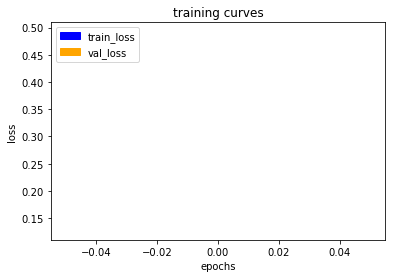

130/129 [==============================] - 76s - loss: 0.4887 - val_loss: 0.1284
Epoch 2/200
129/129 [============================>.] - ETA: 0s - loss: 0.0690

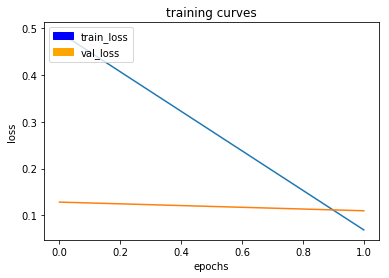

130/129 [==============================] - 72s - loss: 0.0687 - val_loss: 0.1099
Epoch 3/200
129/129 [============================>.] - ETA: 0s - loss: 0.0493

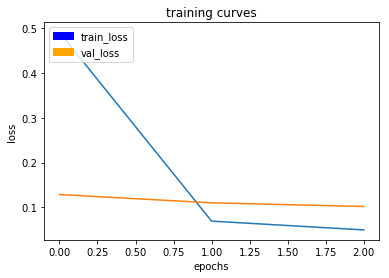

130/129 [==============================] - 72s - loss: 0.0493 - val_loss: 0.1017
Epoch 4/200
129/129 [============================>.] - ETA: 0s - loss: 0.0427

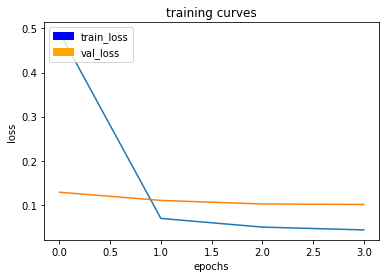

130/129 [==============================] - 72s - loss: 0.0428 - val_loss: 0.1007
Epoch 5/200
129/129 [============================>.] - ETA: 0s - loss: 0.0397

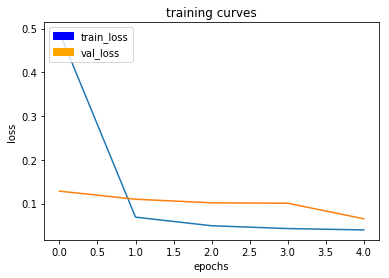

130/129 [==============================] - 72s - loss: 0.0399 - val_loss: 0.0652
Epoch 6/200
129/129 [============================>.] - ETA: 0s - loss: 0.0369

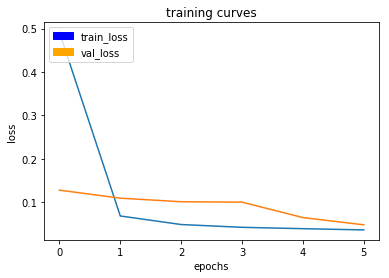

130/129 [==============================] - 72s - loss: 0.0370 - val_loss: 0.0486
Epoch 7/200
129/129 [============================>.] - ETA: 0s - loss: 0.0348

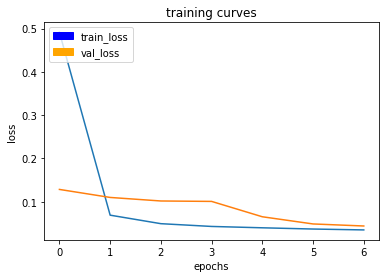

130/129 [==============================] - 72s - loss: 0.0350 - val_loss: 0.0439
Epoch 8/200
129/129 [============================>.] - ETA: 0s - loss: 0.0329

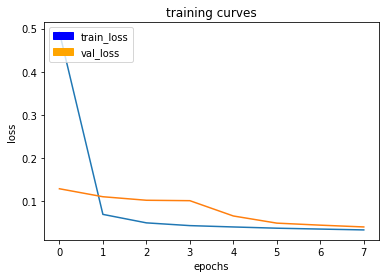

130/129 [==============================] - 72s - loss: 0.0328 - val_loss: 0.0398
Epoch 9/200
129/129 [============================>.] - ETA: 0s - loss: 0.0319

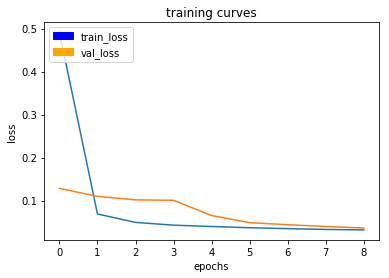

130/129 [==============================] - 72s - loss: 0.0318 - val_loss: 0.0363
Epoch 10/200
129/129 [============================>.] - ETA: 0s - loss: 0.0306

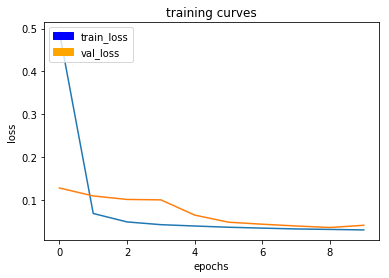

130/129 [==============================] - 72s - loss: 0.0306 - val_loss: 0.0414
Epoch 11/200
129/129 [============================>.] - ETA: 0s - loss: 0.0293

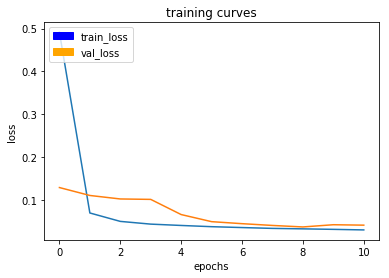

130/129 [==============================] - 72s - loss: 0.0294 - val_loss: 0.0404
Epoch 12/200
129/129 [============================>.] - ETA: 0s - loss: 0.0290

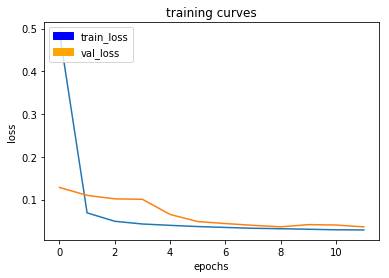

130/129 [==============================] - 72s - loss: 0.0290 - val_loss: 0.0362
Epoch 13/200
129/129 [============================>.] - ETA: 0s - loss: 0.0269

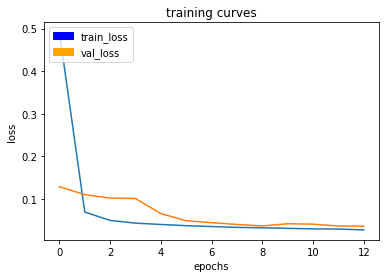

130/129 [==============================] - 72s - loss: 0.0269 - val_loss: 0.0357
Epoch 14/200
129/129 [============================>.] - ETA: 0s - loss: 0.0268

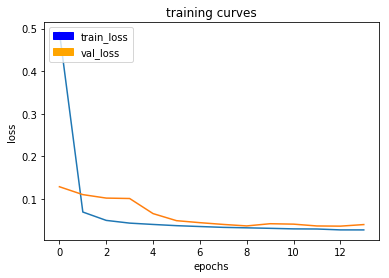

130/129 [==============================] - 71s - loss: 0.0268 - val_loss: 0.0395
Epoch 15/200
129/129 [============================>.] - ETA: 0s - loss: 0.0268

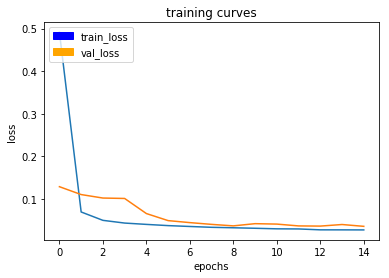

130/129 [==============================] - 72s - loss: 0.0267 - val_loss: 0.0352
Epoch 16/200
129/129 [============================>.] - ETA: 0s - loss: 0.0258

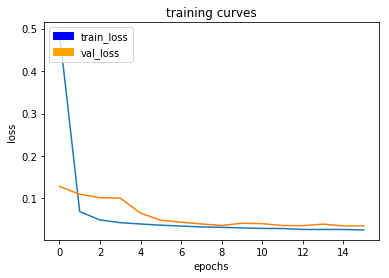

130/129 [==============================] - 72s - loss: 0.0258 - val_loss: 0.0354
Epoch 17/200
129/129 [============================>.] - ETA: 0s - loss: 0.0251

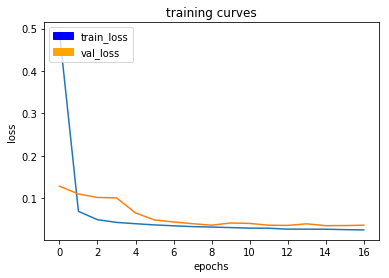

130/129 [==============================] - 72s - loss: 0.0251 - val_loss: 0.0362
Epoch 18/200
129/129 [============================>.] - ETA: 0s - loss: 0.0255

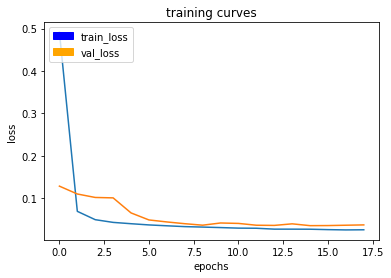

130/129 [==============================] - 72s - loss: 0.0255 - val_loss: 0.0369
Epoch 19/200
129/129 [============================>.] - ETA: 0s - loss: 0.0249

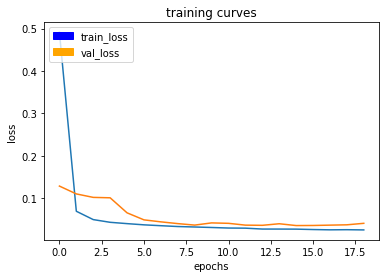

130/129 [==============================] - 72s - loss: 0.0250 - val_loss: 0.0405
Epoch 20/200
129/129 [============================>.] - ETA: 0s - loss: 0.0244

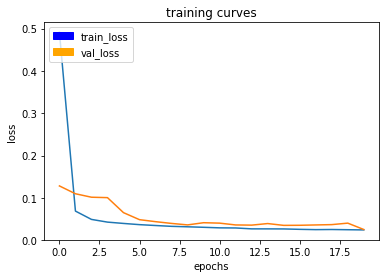

130/129 [==============================] - 72s - loss: 0.0244 - val_loss: 0.0254
Epoch 21/200
129/129 [============================>.] - ETA: 0s - loss: 0.0239

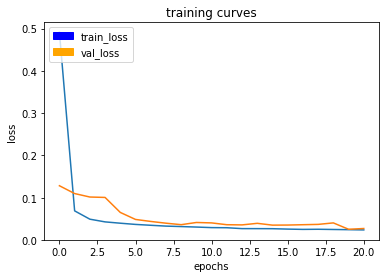

130/129 [==============================] - 72s - loss: 0.0238 - val_loss: 0.0272
Epoch 22/200
129/129 [============================>.] - ETA: 0s - loss: 0.0239

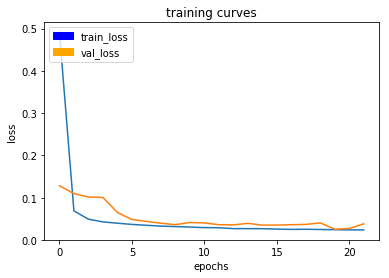

130/129 [==============================] - 72s - loss: 0.0240 - val_loss: 0.0383
Epoch 23/200
129/129 [============================>.] - ETA: 0s - loss: 0.0246

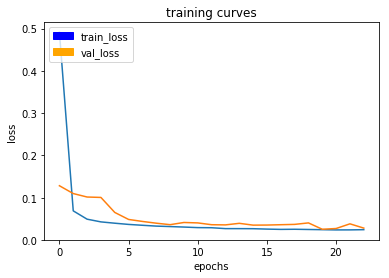

130/129 [==============================] - 72s - loss: 0.0246 - val_loss: 0.0281
Epoch 24/200
129/129 [============================>.] - ETA: 0s - loss: 0.0227

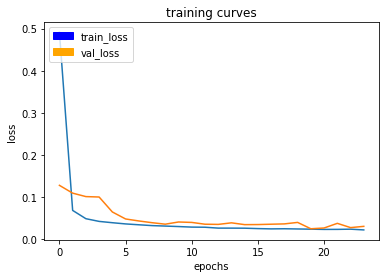

130/129 [==============================] - 72s - loss: 0.0226 - val_loss: 0.0311
Epoch 25/200
129/129 [============================>.] - ETA: 0s - loss: 0.0226

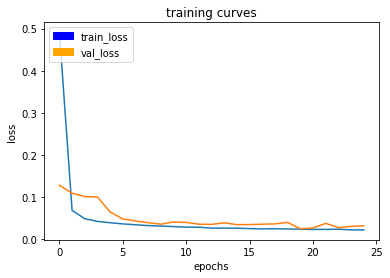

130/129 [==============================] - 72s - loss: 0.0228 - val_loss: 0.0324
Epoch 26/200
129/129 [============================>.] - ETA: 0s - loss: 0.0230

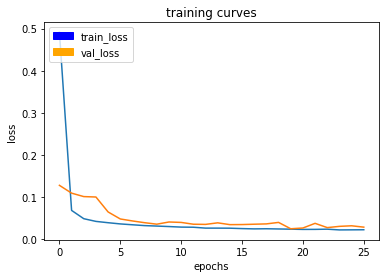

130/129 [==============================] - 72s - loss: 0.0233 - val_loss: 0.0292
Epoch 27/200
129/129 [============================>.] - ETA: 0s - loss: 0.0225

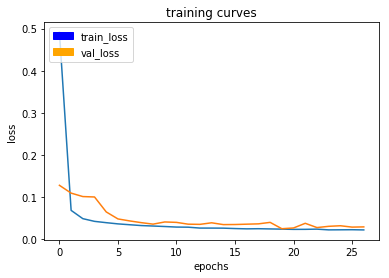

130/129 [==============================] - 72s - loss: 0.0225 - val_loss: 0.0297
Epoch 28/200
129/129 [============================>.] - ETA: 0s - loss: 0.0215

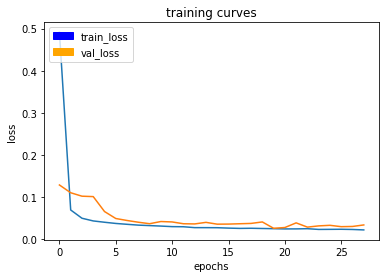

130/129 [==============================] - 72s - loss: 0.0215 - val_loss: 0.0333
Epoch 29/200
129/129 [============================>.] - ETA: 0s - loss: 0.0213

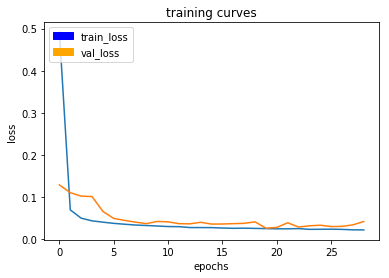

130/129 [==============================] - 72s - loss: 0.0213 - val_loss: 0.0413
Epoch 30/200
129/129 [============================>.] - ETA: 0s - loss: 0.0220

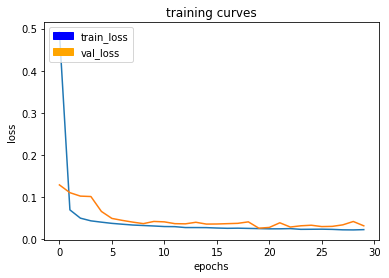

130/129 [==============================] - 72s - loss: 0.0220 - val_loss: 0.0310
Epoch 31/200
129/129 [============================>.] - ETA: 0s - loss: 0.0210

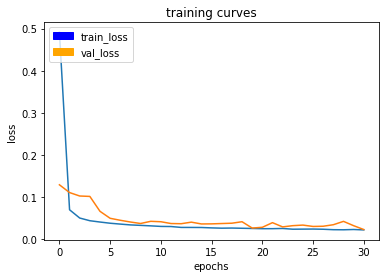

130/129 [==============================] - 72s - loss: 0.0211 - val_loss: 0.0219
Epoch 32/200
129/129 [============================>.] - ETA: 0s - loss: 0.0212

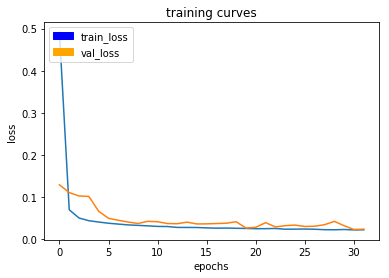

130/129 [==============================] - 72s - loss: 0.0213 - val_loss: 0.0228
Epoch 33/200
129/129 [============================>.] - ETA: 0s - loss: 0.0213

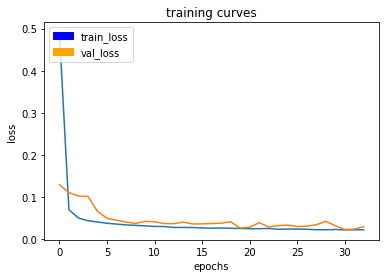

130/129 [==============================] - 72s - loss: 0.0213 - val_loss: 0.0285
Epoch 34/200
129/129 [============================>.] - ETA: 0s - loss: 0.0214

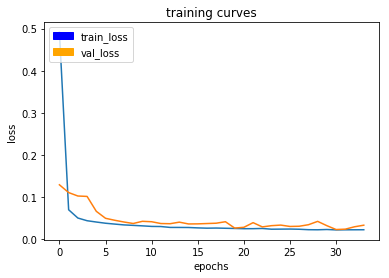

130/129 [==============================] - 72s - loss: 0.0214 - val_loss: 0.0322
Epoch 35/200
129/129 [============================>.] - ETA: 0s - loss: 0.0208

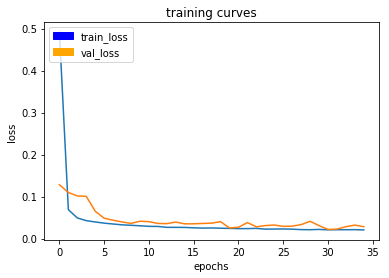

130/129 [==============================] - 72s - loss: 0.0207 - val_loss: 0.0285
Epoch 36/200
129/129 [============================>.] - ETA: 0s - loss: 0.0205

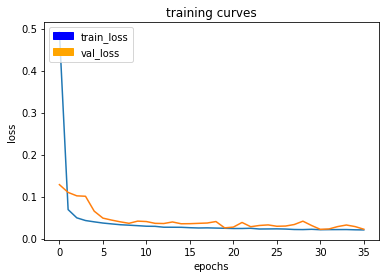

130/129 [==============================] - 72s - loss: 0.0205 - val_loss: 0.0222
Epoch 37/200
129/129 [============================>.] - ETA: 0s - loss: 0.0197

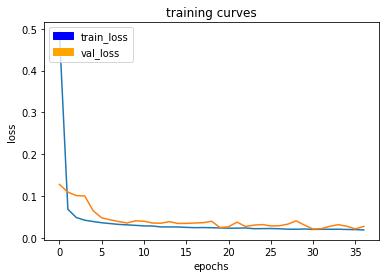

130/129 [==============================] - 72s - loss: 0.0197 - val_loss: 0.0281
Epoch 38/200
129/129 [============================>.] - ETA: 0s - loss: 0.0205

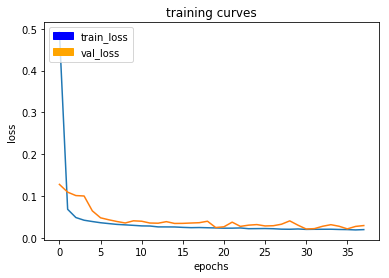

130/129 [==============================] - 72s - loss: 0.0205 - val_loss: 0.0302
Epoch 39/200
129/129 [============================>.] - ETA: 0s - loss: 0.0192

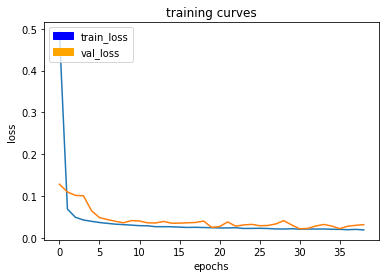

130/129 [==============================] - 72s - loss: 0.0192 - val_loss: 0.0317
Epoch 40/200
129/129 [============================>.] - ETA: 0s - loss: 0.0204

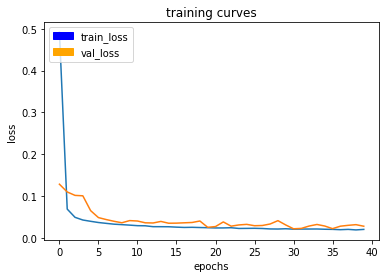

130/129 [==============================] - 72s - loss: 0.0206 - val_loss: 0.0280
Epoch 41/200
129/129 [============================>.] - ETA: 0s - loss: 0.0195

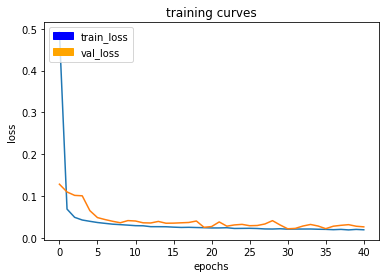

130/129 [==============================] - 72s - loss: 0.0195 - val_loss: 0.0265
Epoch 42/200
129/129 [============================>.] - ETA: 0s - loss: 0.0201

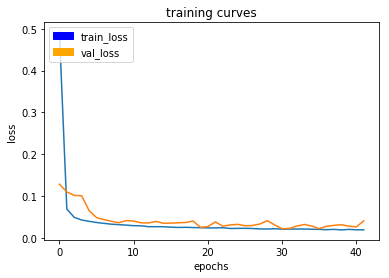

130/129 [==============================] - 72s - loss: 0.0201 - val_loss: 0.0408
Epoch 43/200
129/129 [============================>.] - ETA: 0s - loss: 0.0256

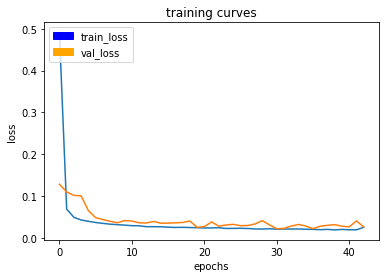

130/129 [==============================] - 72s - loss: 0.0255 - val_loss: 0.0259
Epoch 44/200
129/129 [============================>.] - ETA: 0s - loss: 0.0199

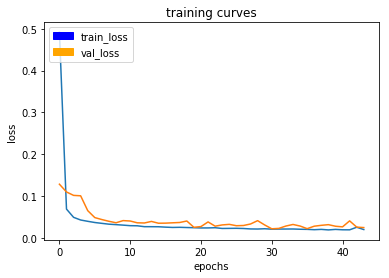

130/129 [==============================] - 72s - loss: 0.0200 - val_loss: 0.0248
Epoch 45/200
129/129 [============================>.] - ETA: 0s - loss: 0.0190

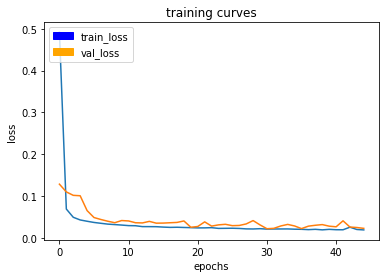

130/129 [==============================] - 72s - loss: 0.0190 - val_loss: 0.0228
Epoch 46/200
129/129 [============================>.] - ETA: 0s - loss: 0.0188

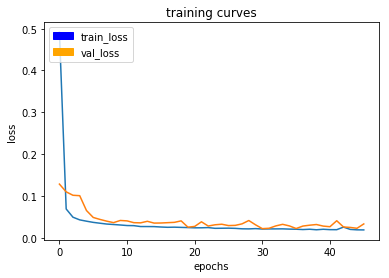

130/129 [==============================] - 72s - loss: 0.0189 - val_loss: 0.0332
Epoch 47/200
129/129 [============================>.] - ETA: 0s - loss: 0.0188

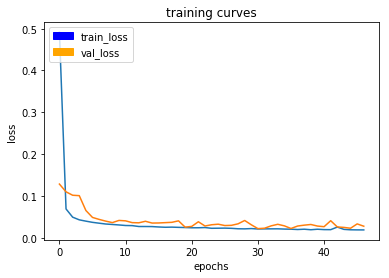

130/129 [==============================] - 72s - loss: 0.0188 - val_loss: 0.0276
Epoch 48/200
129/129 [============================>.] - ETA: 0s - loss: 0.0181

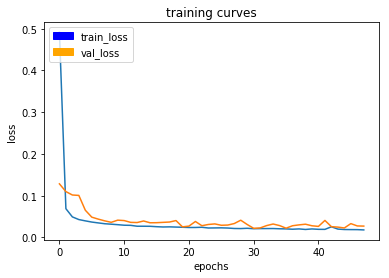

130/129 [==============================] - 72s - loss: 0.0183 - val_loss: 0.0272
Epoch 49/200
129/129 [============================>.] - ETA: 0s - loss: 0.0190

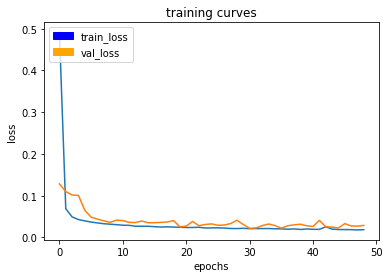

130/129 [==============================] - 72s - loss: 0.0189 - val_loss: 0.0288
Epoch 50/200
129/129 [============================>.] - ETA: 0s - loss: 0.0192

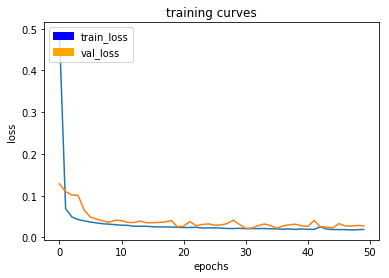

130/129 [==============================] - 72s - loss: 0.0192 - val_loss: 0.0279
Epoch 51/200
129/129 [============================>.] - ETA: 0s - loss: 0.0181

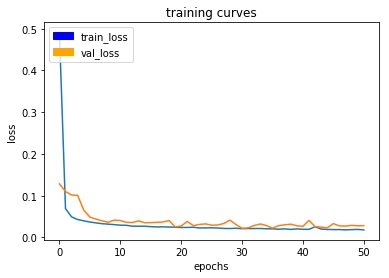

130/129 [==============================] - 72s - loss: 0.0181 - val_loss: 0.0283
Epoch 52/200
129/129 [============================>.] - ETA: 0s - loss: 0.0183

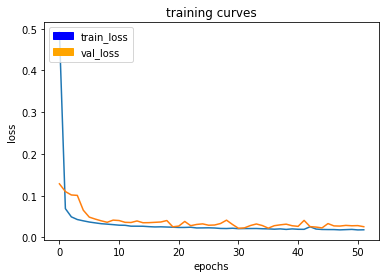

130/129 [==============================] - 72s - loss: 0.0183 - val_loss: 0.0257
Epoch 53/200
129/129 [============================>.] - ETA: 0s - loss: 0.0174

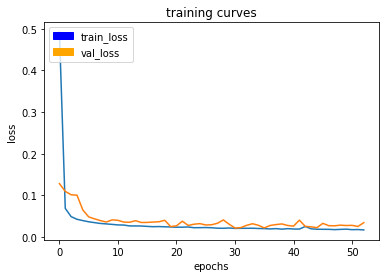

130/129 [==============================] - 72s - loss: 0.0174 - val_loss: 0.0348
Epoch 54/200
129/129 [============================>.] - ETA: 0s - loss: 0.0190

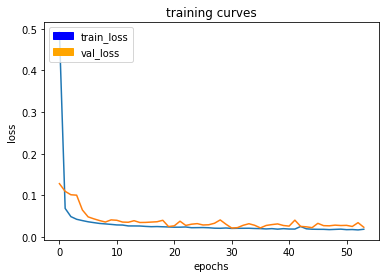

130/129 [==============================] - 72s - loss: 0.0191 - val_loss: 0.0237
Epoch 55/200
129/129 [============================>.] - ETA: 0s - loss: 0.0195

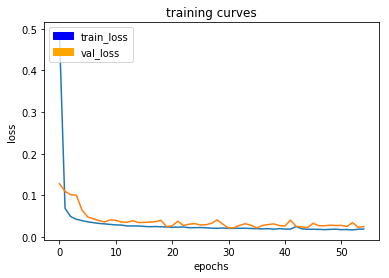

130/129 [==============================] - 72s - loss: 0.0196 - val_loss: 0.0252
Epoch 56/200
129/129 [============================>.] - ETA: 0s - loss: 0.0174

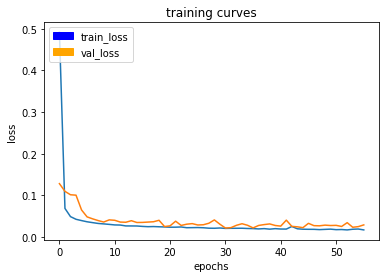

130/129 [==============================] - 72s - loss: 0.0175 - val_loss: 0.0294
Epoch 57/200
129/129 [============================>.] - ETA: 0s - loss: 0.0182

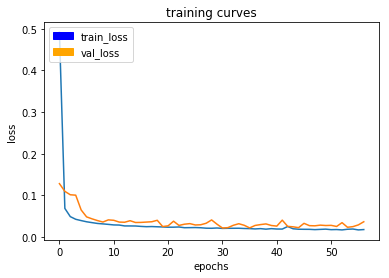

130/129 [==============================] - 72s - loss: 0.0182 - val_loss: 0.0370
Epoch 58/200
129/129 [============================>.] - ETA: 0s - loss: 0.0178

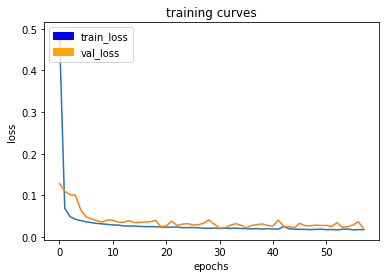

130/129 [==============================] - 72s - loss: 0.0179 - val_loss: 0.0194
Epoch 59/200
129/129 [============================>.] - ETA: 0s - loss: 0.0182

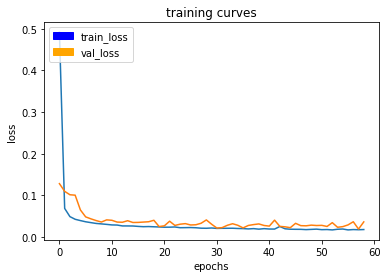

130/129 [==============================] - 72s - loss: 0.0183 - val_loss: 0.0366
Epoch 60/200
129/129 [============================>.] - ETA: 0s - loss: 0.0179

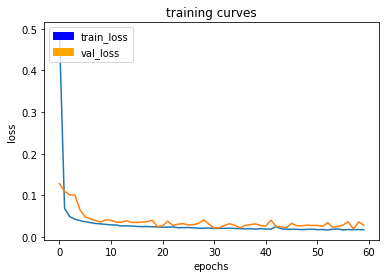

130/129 [==============================] - 72s - loss: 0.0179 - val_loss: 0.0285
Epoch 61/200
129/129 [============================>.] - ETA: 0s - loss: 0.0177

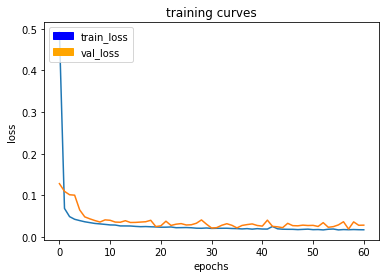

130/129 [==============================] - 72s - loss: 0.0177 - val_loss: 0.0288
Epoch 62/200
129/129 [============================>.] - ETA: 0s - loss: 0.0174

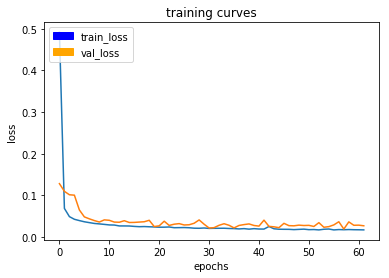

130/129 [==============================] - 72s - loss: 0.0175 - val_loss: 0.0273
Epoch 63/200
129/129 [============================>.] - ETA: 0s - loss: 0.0170

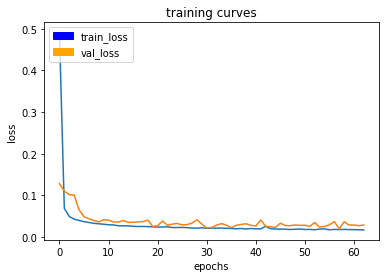

130/129 [==============================] - 72s - loss: 0.0170 - val_loss: 0.0287
Epoch 64/200
129/129 [============================>.] - ETA: 0s - loss: 0.0181

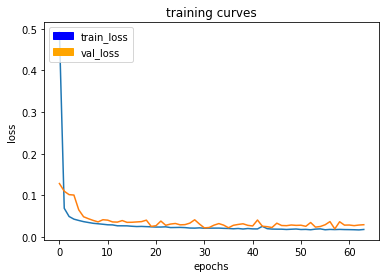

130/129 [==============================] - 72s - loss: 0.0181 - val_loss: 0.0295
Epoch 65/200
129/129 [============================>.] - ETA: 0s - loss: 0.0182

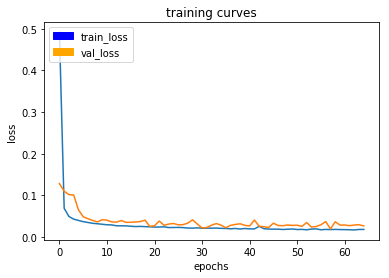

130/129 [==============================] - 72s - loss: 0.0183 - val_loss: 0.0266
Epoch 66/200
129/129 [============================>.] - ETA: 0s - loss: 0.0168

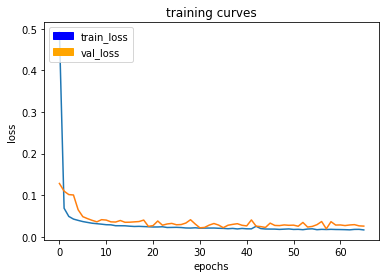

130/129 [==============================] - 72s - loss: 0.0168 - val_loss: 0.0260
Epoch 67/200
129/129 [============================>.] - ETA: 0s - loss: 0.0166

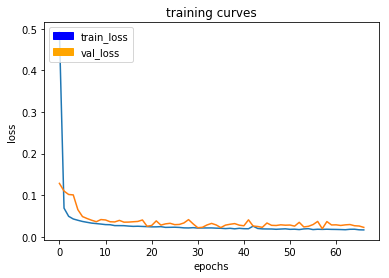

130/129 [==============================] - 72s - loss: 0.0166 - val_loss: 0.0226
Epoch 68/200
129/129 [============================>.] - ETA: 0s - loss: 0.0162

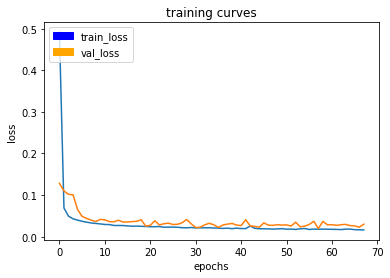

130/129 [==============================] - 73s - loss: 0.0162 - val_loss: 0.0299
Epoch 69/200
129/129 [============================>.] - ETA: 0s - loss: 0.0162

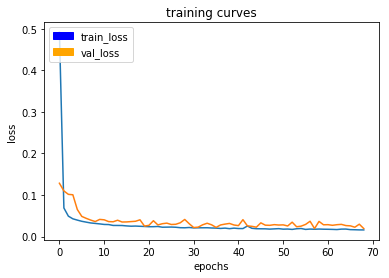

130/129 [==============================] - 72s - loss: 0.0162 - val_loss: 0.0194
Epoch 70/200
129/129 [============================>.] - ETA: 0s - loss: 0.0170

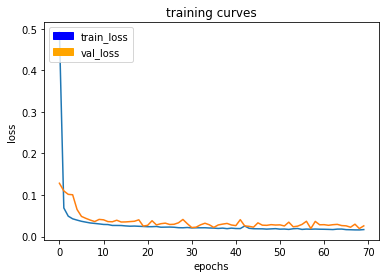

130/129 [==============================] - 72s - loss: 0.0170 - val_loss: 0.0259
Epoch 71/200
129/129 [============================>.] - ETA: 0s - loss: 0.0164

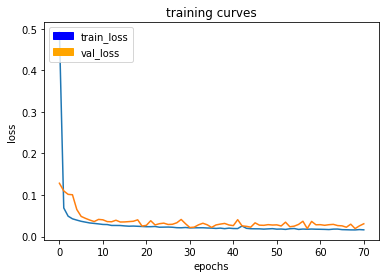

130/129 [==============================] - 72s - loss: 0.0164 - val_loss: 0.0309
Epoch 72/200
129/129 [============================>.] - ETA: 0s - loss: 0.0170

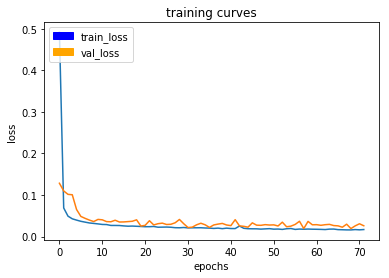

130/129 [==============================] - 72s - loss: 0.0170 - val_loss: 0.0261
Epoch 73/200
129/129 [============================>.] - ETA: 0s - loss: 0.0158

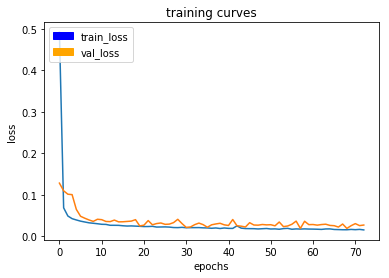

130/129 [==============================] - 72s - loss: 0.0158 - val_loss: 0.0275
Epoch 74/200
129/129 [============================>.] - ETA: 0s - loss: 0.0162

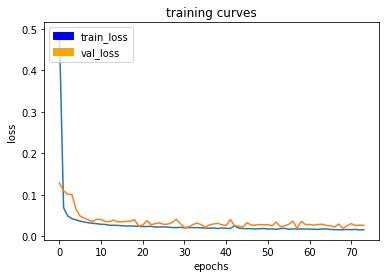

130/129 [==============================] - 72s - loss: 0.0162 - val_loss: 0.0266
Epoch 75/200
129/129 [============================>.] - ETA: 0s - loss: 0.0163

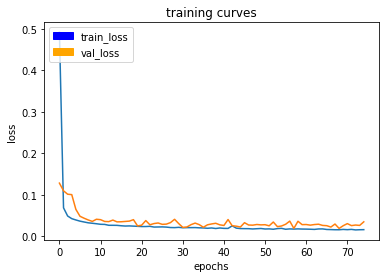

130/129 [==============================] - 72s - loss: 0.0164 - val_loss: 0.0352
Epoch 76/200
129/129 [============================>.] - ETA: 0s - loss: 0.0168

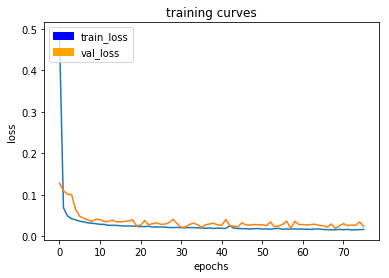

130/129 [==============================] - 72s - loss: 0.0168 - val_loss: 0.0236
Epoch 77/200
129/129 [============================>.] - ETA: 0s - loss: 0.0161

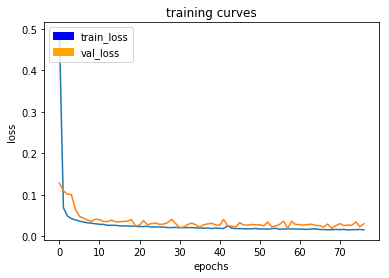

130/129 [==============================] - 72s - loss: 0.0162 - val_loss: 0.0305
Epoch 78/200
129/129 [============================>.] - ETA: 0s - loss: 0.0174

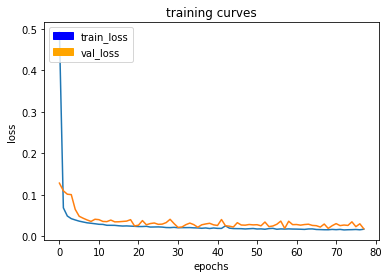

130/129 [==============================] - 72s - loss: 0.0175 - val_loss: 0.0185
Epoch 79/200
129/129 [============================>.] - ETA: 0s - loss: 0.0162

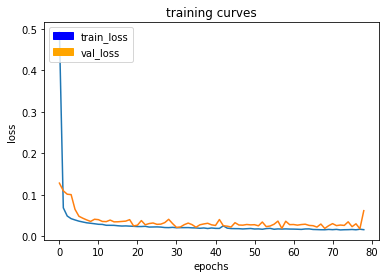

130/129 [==============================] - 72s - loss: 0.0174 - val_loss: 0.0621
Epoch 80/200
129/129 [============================>.] - ETA: 0s - loss: 0.0271

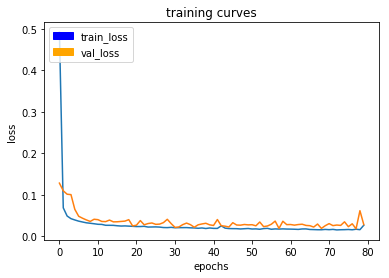

130/129 [==============================] - 72s - loss: 0.0271 - val_loss: 0.0286
Epoch 81/200
129/129 [============================>.] - ETA: 0s - loss: 0.0200

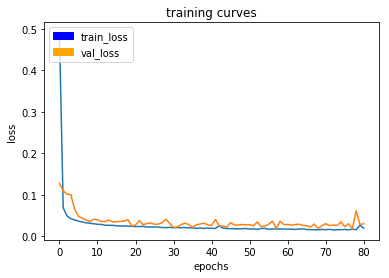

130/129 [==============================] - 72s - loss: 0.0200 - val_loss: 0.0308
Epoch 82/200
129/129 [============================>.] - ETA: 0s - loss: 0.0170

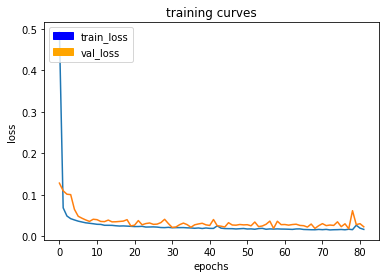

130/129 [==============================] - 72s - loss: 0.0173 - val_loss: 0.0233
Epoch 83/200
129/129 [============================>.] - ETA: 0s - loss: 0.0176

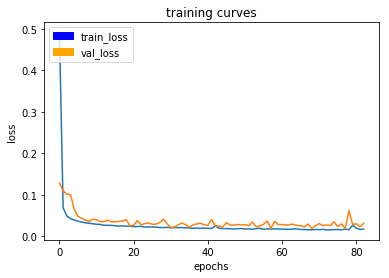

130/129 [==============================] - 72s - loss: 0.0178 - val_loss: 0.0319
Epoch 84/200
129/129 [============================>.] - ETA: 0s - loss: 0.0163

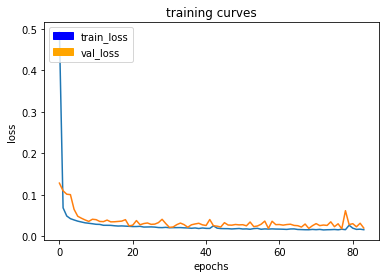

130/129 [==============================] - 72s - loss: 0.0164 - val_loss: 0.0202
Epoch 85/200
129/129 [============================>.] - ETA: 0s - loss: 0.0158

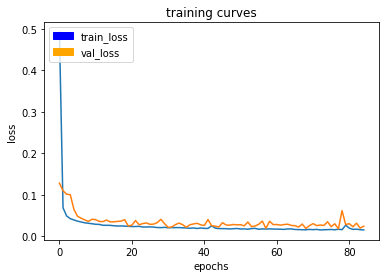

130/129 [==============================] - 72s - loss: 0.0159 - val_loss: 0.0247
Epoch 86/200
129/129 [============================>.] - ETA: 0s - loss: 0.0156

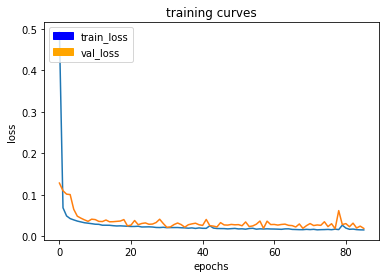

130/129 [==============================] - 72s - loss: 0.0156 - val_loss: 0.0192
Epoch 87/200
129/129 [============================>.] - ETA: 0s - loss: 0.0160

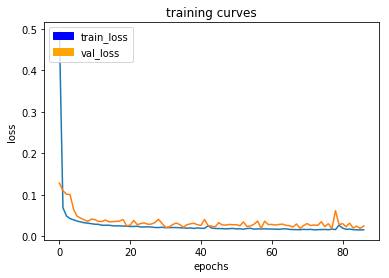

130/129 [==============================] - 72s - loss: 0.0160 - val_loss: 0.0252
Epoch 88/200
129/129 [============================>.] - ETA: 0s - loss: 0.0157

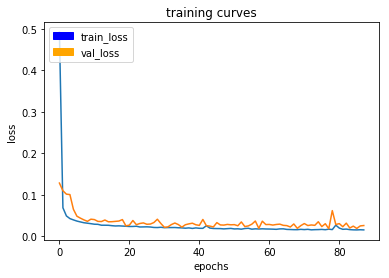

130/129 [==============================] - 72s - loss: 0.0156 - val_loss: 0.0262
Epoch 89/200
129/129 [============================>.] - ETA: 0s - loss: 0.0153

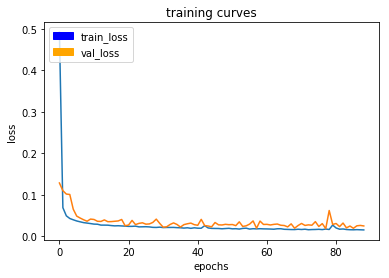

130/129 [==============================] - 72s - loss: 0.0153 - val_loss: 0.0249
Epoch 90/200
129/129 [============================>.] - ETA: 0s - loss: 0.0155

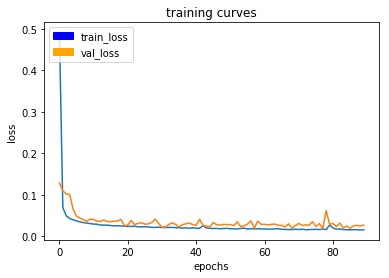

130/129 [==============================] - 72s - loss: 0.0155 - val_loss: 0.0271
Epoch 91/200
129/129 [============================>.] - ETA: 0s - loss: 0.0154

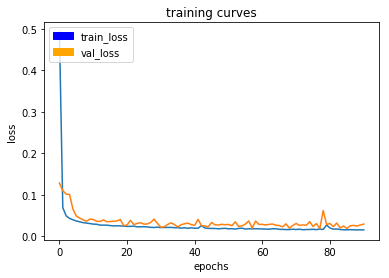

130/129 [==============================] - 72s - loss: 0.0154 - val_loss: 0.0295
Epoch 92/200
129/129 [============================>.] - ETA: 0s - loss: 0.0150

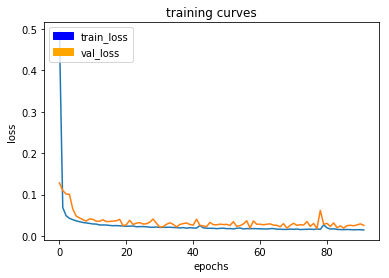

130/129 [==============================] - 72s - loss: 0.0149 - val_loss: 0.0260
Epoch 93/200
129/129 [============================>.] - ETA: 0s - loss: 0.0154

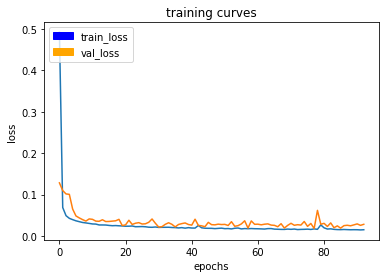

130/129 [==============================] - 72s - loss: 0.0154 - val_loss: 0.0285
Epoch 94/200
129/129 [============================>.] - ETA: 0s - loss: 0.0152

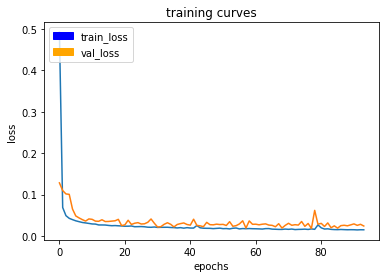

130/129 [==============================] - 72s - loss: 0.0152 - val_loss: 0.0244
Epoch 95/200
129/129 [============================>.] - ETA: 0s - loss: 0.0176

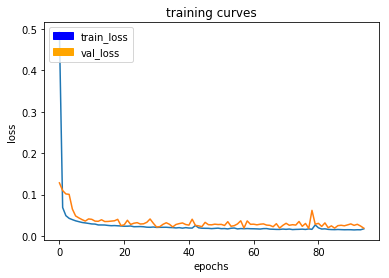

130/129 [==============================] - 72s - loss: 0.0176 - val_loss: 0.0191
Epoch 96/200
129/129 [============================>.] - ETA: 0s - loss: 0.0155

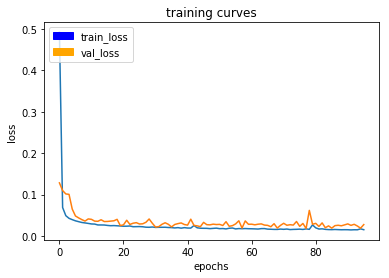

130/129 [==============================] - 72s - loss: 0.0155 - val_loss: 0.0278
Epoch 97/200
129/129 [============================>.] - ETA: 0s - loss: 0.0173

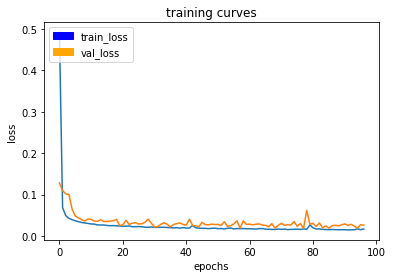

130/129 [==============================] - 72s - loss: 0.0173 - val_loss: 0.0262
Epoch 98/200
129/129 [============================>.] - ETA: 0s - loss: 0.0150

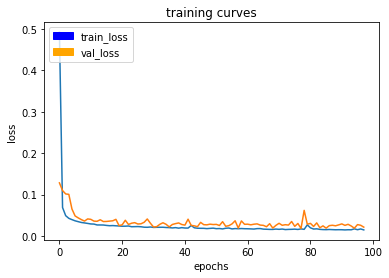

130/129 [==============================] - 72s - loss: 0.0150 - val_loss: 0.0216
Epoch 99/200
129/129 [============================>.] - ETA: 0s - loss: 0.0148

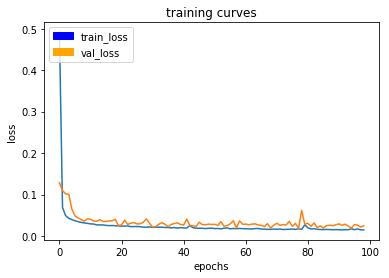

130/129 [==============================] - 72s - loss: 0.0149 - val_loss: 0.0248
Epoch 100/200
129/129 [============================>.] - ETA: 0s - loss: 0.0161

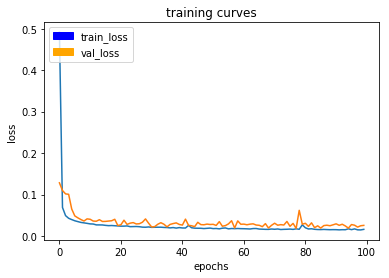

130/129 [==============================] - 72s - loss: 0.0163 - val_loss: 0.0258
Epoch 101/200
129/129 [============================>.] - ETA: 0s - loss: 0.0148

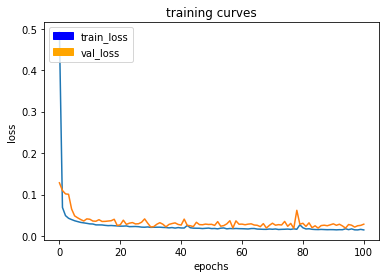

130/129 [==============================] - 72s - loss: 0.0148 - val_loss: 0.0286
Epoch 102/200
129/129 [============================>.] - ETA: 0s - loss: 0.0146

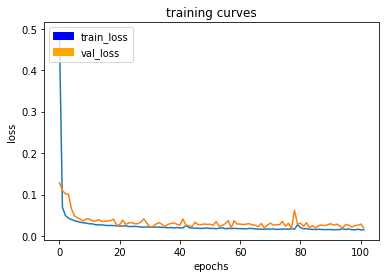

130/129 [==============================] - 72s - loss: 0.0146 - val_loss: 0.0195
Epoch 103/200
129/129 [============================>.] - ETA: 0s - loss: 0.0153

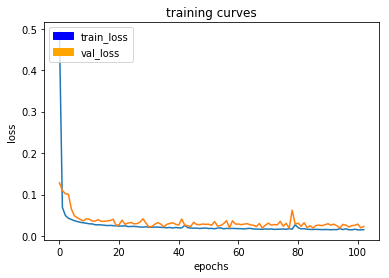

130/129 [==============================] - 72s - loss: 0.0154 - val_loss: 0.0229
Epoch 104/200
129/129 [============================>.] - ETA: 0s - loss: 0.0151

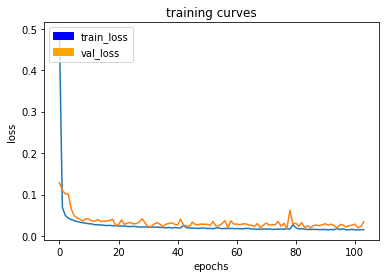

130/129 [==============================] - 72s - loss: 0.0151 - val_loss: 0.0340
Epoch 105/200
129/129 [============================>.] - ETA: 0s - loss: 0.0146

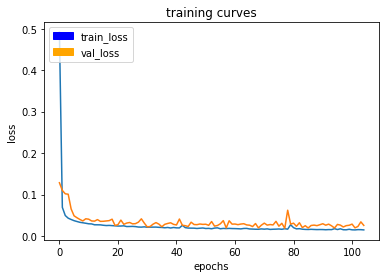

130/129 [==============================] - 72s - loss: 0.0146 - val_loss: 0.0255
Epoch 106/200
129/129 [============================>.] - ETA: 0s - loss: 0.0146

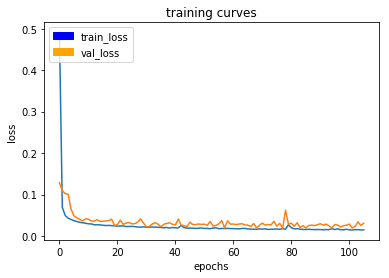

130/129 [==============================] - 72s - loss: 0.0146 - val_loss: 0.0306
Epoch 107/200
129/129 [============================>.] - ETA: 0s - loss: 0.0164

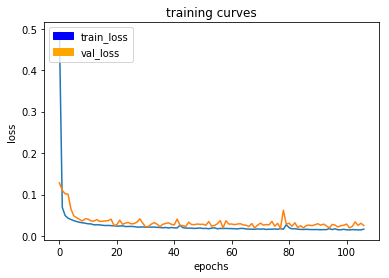

130/129 [==============================] - 72s - loss: 0.0164 - val_loss: 0.0251
Epoch 108/200
129/129 [============================>.] - ETA: 0s - loss: 0.0153

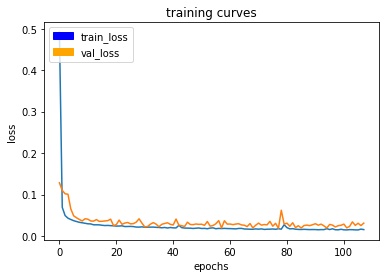

130/129 [==============================] - 72s - loss: 0.0154 - val_loss: 0.0309
Epoch 109/200
129/129 [============================>.] - ETA: 0s - loss: 0.0166

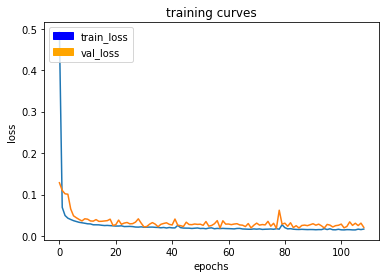

130/129 [==============================] - 72s - loss: 0.0166 - val_loss: 0.0207
Epoch 110/200
129/129 [============================>.] - ETA: 0s - loss: 0.0148

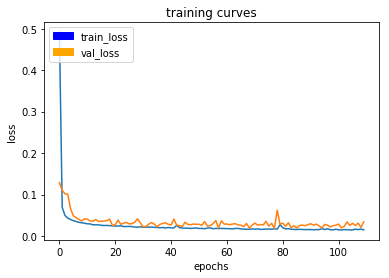

130/129 [==============================] - 72s - loss: 0.0150 - val_loss: 0.0339
Epoch 111/200
129/129 [============================>.] - ETA: 0s - loss: 0.0148

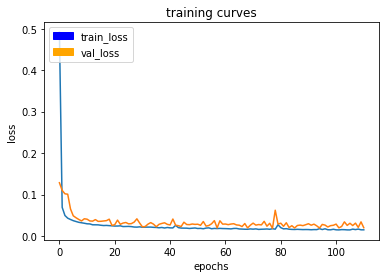

130/129 [==============================] - 72s - loss: 0.0148 - val_loss: 0.0198
Epoch 112/200
129/129 [============================>.] - ETA: 0s - loss: 0.0142

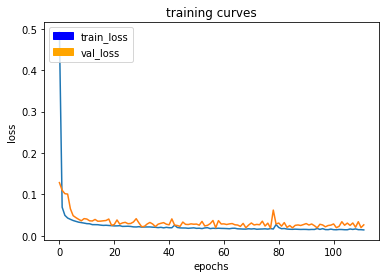

130/129 [==============================] - 72s - loss: 0.0142 - val_loss: 0.0264
Epoch 113/200
129/129 [============================>.] - ETA: 0s - loss: 0.0173

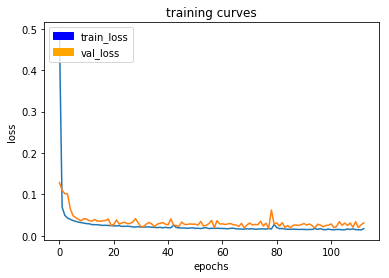

130/129 [==============================] - 72s - loss: 0.0174 - val_loss: 0.0312
Epoch 114/200
129/129 [============================>.] - ETA: 0s - loss: 0.0147

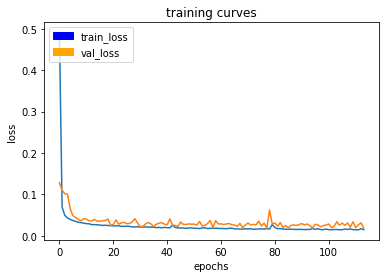

130/129 [==============================] - 72s - loss: 0.0147 - val_loss: 0.0190
Epoch 115/200
129/129 [============================>.] - ETA: 0s - loss: 0.0142

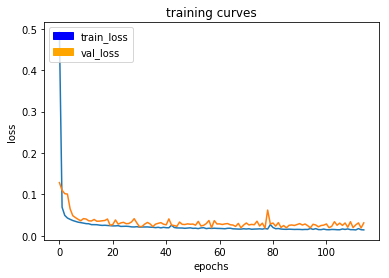

130/129 [==============================] - 72s - loss: 0.0142 - val_loss: 0.0312
Epoch 116/200
129/129 [============================>.] - ETA: 0s - loss: 0.0140

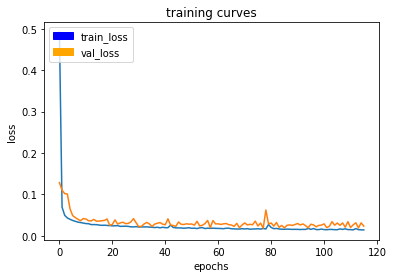

130/129 [==============================] - 72s - loss: 0.0141 - val_loss: 0.0232
Epoch 117/200
129/129 [============================>.] - ETA: 0s - loss: 0.0154

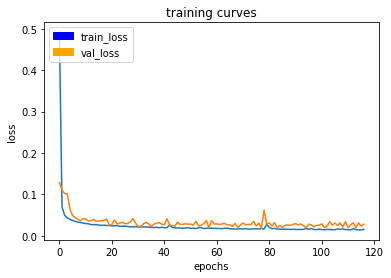

130/129 [==============================] - 72s - loss: 0.0154 - val_loss: 0.0278
Epoch 118/200
129/129 [============================>.] - ETA: 0s - loss: 0.0145

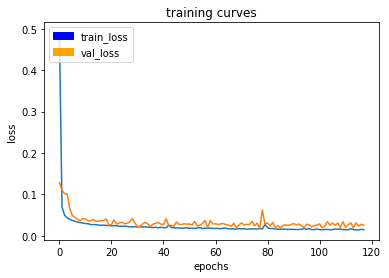

130/129 [==============================] - 72s - loss: 0.0145 - val_loss: 0.0255
Epoch 119/200
129/129 [============================>.] - ETA: 0s - loss: 0.0143

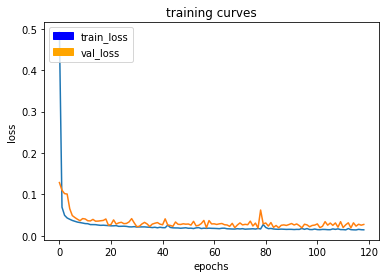

130/129 [==============================] - 72s - loss: 0.0143 - val_loss: 0.0272
Epoch 120/200
129/129 [============================>.] - ETA: 0s - loss: 0.0143

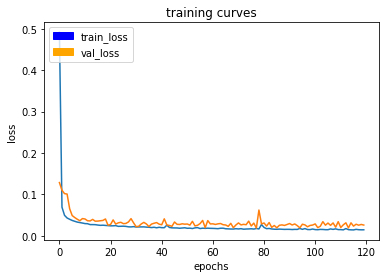

130/129 [==============================] - 72s - loss: 0.0145 - val_loss: 0.0258
Epoch 121/200
129/129 [============================>.] - ETA: 0s - loss: 0.0145

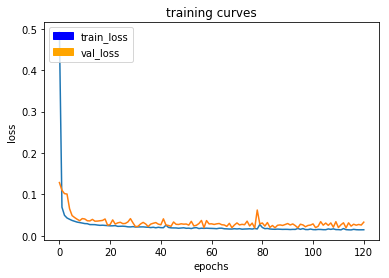

130/129 [==============================] - 72s - loss: 0.0145 - val_loss: 0.0328
Epoch 122/200
129/129 [============================>.] - ETA: 0s - loss: 0.0146

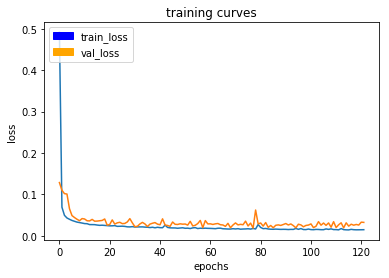

130/129 [==============================] - 72s - loss: 0.0147 - val_loss: 0.0322
Epoch 123/200
129/129 [============================>.] - ETA: 0s - loss: 0.0140

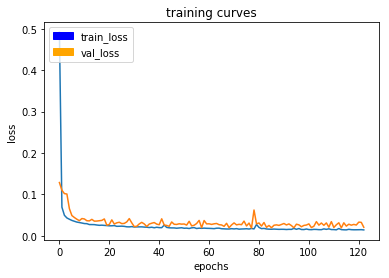

130/129 [==============================] - 72s - loss: 0.0140 - val_loss: 0.0203
Epoch 124/200
129/129 [============================>.] - ETA: 0s - loss: 0.0138

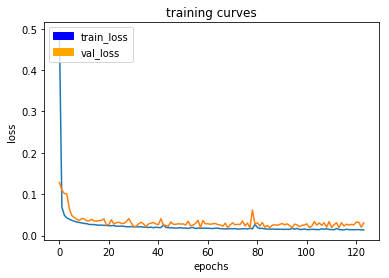

130/129 [==============================] - 72s - loss: 0.0138 - val_loss: 0.0310
Epoch 125/200
129/129 [============================>.] - ETA: 0s - loss: 0.0137

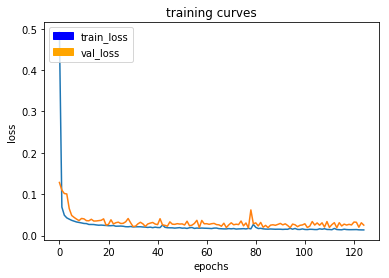

130/129 [==============================] - 72s - loss: 0.0138 - val_loss: 0.0253
Epoch 126/200
129/129 [============================>.] - ETA: 0s - loss: 0.0138

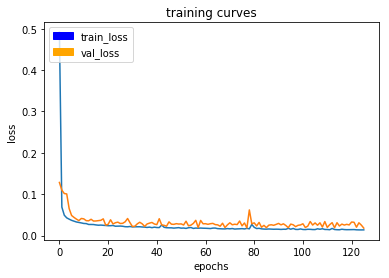

130/129 [==============================] - 72s - loss: 0.0139 - val_loss: 0.0181
Epoch 127/200
129/129 [============================>.] - ETA: 0s - loss: 0.0139

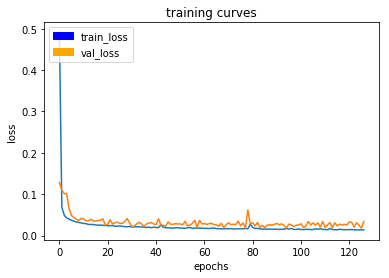

130/129 [==============================] - 72s - loss: 0.0140 - val_loss: 0.0341
Epoch 128/200
129/129 [============================>.] - ETA: 0s - loss: 0.0141

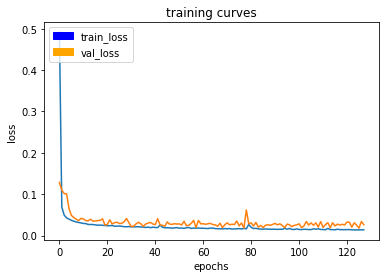

130/129 [==============================] - 72s - loss: 0.0140 - val_loss: 0.0264
Epoch 129/200
129/129 [============================>.] - ETA: 0s - loss: 0.0136

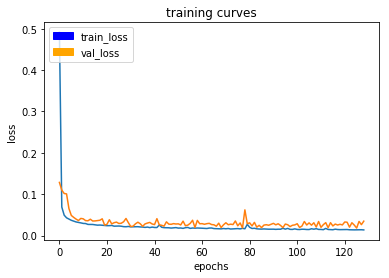

130/129 [==============================] - 72s - loss: 0.0137 - val_loss: 0.0348
Epoch 130/200
129/129 [============================>.] - ETA: 0s - loss: 0.0162

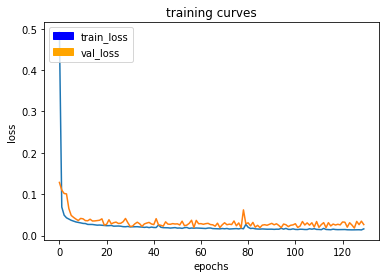

130/129 [==============================] - 72s - loss: 0.0162 - val_loss: 0.0265
Epoch 131/200
129/129 [============================>.] - ETA: 0s - loss: 0.0140

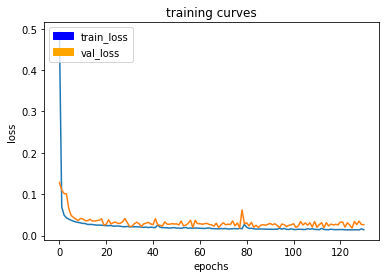

130/129 [==============================] - 72s - loss: 0.0140 - val_loss: 0.0262
Epoch 132/200
129/129 [============================>.] - ETA: 0s - loss: 0.0138

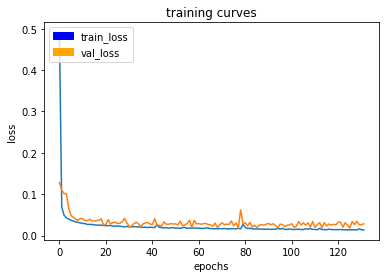

130/129 [==============================] - 72s - loss: 0.0138 - val_loss: 0.0284
Epoch 133/200
129/129 [============================>.] - ETA: 0s - loss: 0.0144

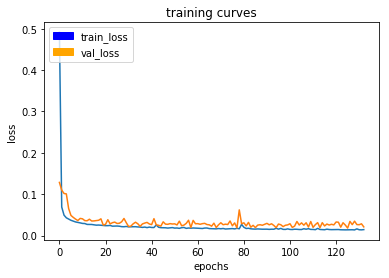

130/129 [==============================] - 72s - loss: 0.0144 - val_loss: 0.0209
Epoch 134/200
129/129 [============================>.] - ETA: 0s - loss: 0.0148

130/129 [==============================] - 72s - loss: 0.0148 - val_loss: 0.0269
Epoch 135/200
129/129 [============================>.] - ETA: 0s - loss: 0.0146

130/129 [==============================] - 72s - loss: 0.0147 - val_loss: 0.0247
Epoch 136/200
129/129 [============================>.] - ETA: 0s - loss: 0.0141

130/129 [==============================] - 72s - loss: 0.0141 - val_loss: 0.0331
Epoch 137/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0266
Epoch 138/200
129/129 [============================>.] - ETA: 0s - loss: 0.0136

130/129 [==============================] - 72s - loss: 0.0136 - val_loss: 0.0212
Epoch 139/200
129/129 [============================>.] - ETA: 0s - loss: 0.0141

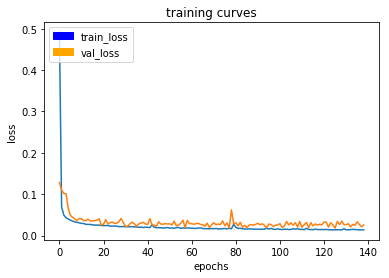

130/129 [==============================] - 72s - loss: 0.0141 - val_loss: 0.0254
Epoch 140/200
129/129 [============================>.] - ETA: 0s - loss: 0.0142

130/129 [==============================] - 72s - loss: 0.0142 - val_loss: 0.0359
Epoch 141/200
129/129 [============================>.] - ETA: 0s - loss: 0.0161

130/129 [==============================] - 72s - loss: 0.0161 - val_loss: 0.0289
Epoch 142/200
129/129 [============================>.] - ETA: 0s - loss: 0.0139

130/129 [==============================] - 72s - loss: 0.0139 - val_loss: 0.0253
Epoch 143/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0284
Epoch 144/200
129/129 [============================>.] - ETA: 0s - loss: 0.0136

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0361
Epoch 145/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0189
Epoch 146/200
129/129 [============================>.] - ETA: 0s - loss: 0.0138

130/129 [==============================] - 72s - loss: 0.0138 - val_loss: 0.0332
Epoch 147/200
129/129 [============================>.] - ETA: 0s - loss: 0.0144

130/129 [==============================] - 72s - loss: 0.0145 - val_loss: 0.0229
Epoch 148/200
129/129 [============================>.] - ETA: 0s - loss: 0.0149

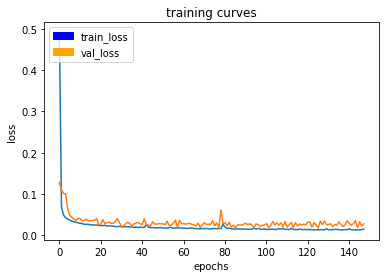

130/129 [==============================] - 71s - loss: 0.0149 - val_loss: 0.0280
Epoch 149/200
129/129 [============================>.] - ETA: 0s - loss: 0.0132

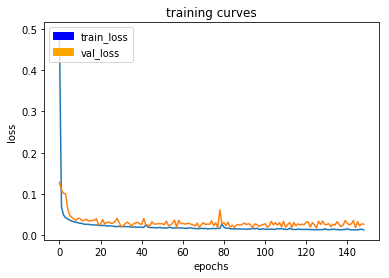

130/129 [==============================] - 72s - loss: 0.0132 - val_loss: 0.0267
Epoch 150/200
129/129 [============================>.] - ETA: 0s - loss: 0.0134

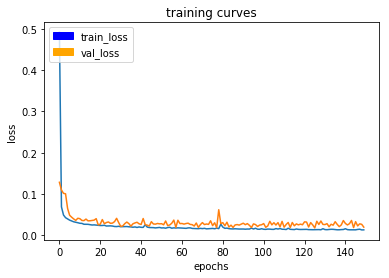

130/129 [==============================] - 72s - loss: 0.0134 - val_loss: 0.0199
Epoch 151/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

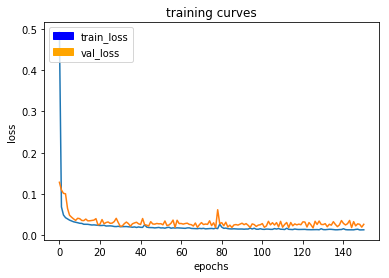

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0268
Epoch 152/200
129/129 [============================>.] - ETA: 0s - loss: 0.0140

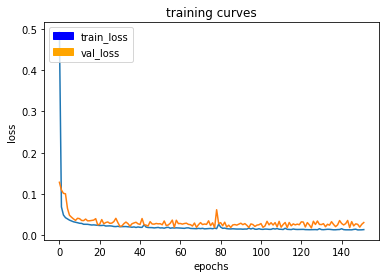

130/129 [==============================] - 72s - loss: 0.0141 - val_loss: 0.0311
Epoch 153/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

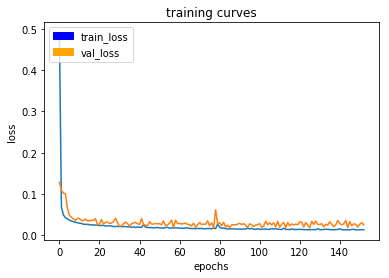

130/129 [==============================] - 72s - loss: 0.0137 - val_loss: 0.0249
Epoch 154/200
129/129 [============================>.] - ETA: 0s - loss: 0.0169

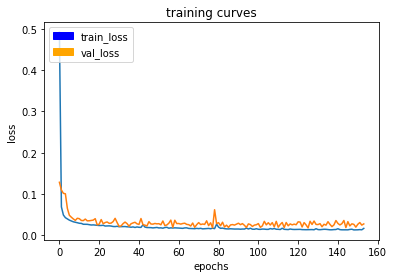

130/129 [==============================] - 72s - loss: 0.0169 - val_loss: 0.0278
Epoch 155/200
129/129 [============================>.] - ETA: 0s - loss: 0.0137

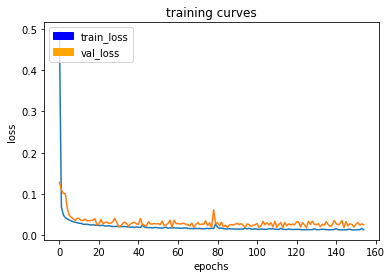

130/129 [==============================] - 72s - loss: 0.0137 - val_loss: 0.0256
Epoch 156/200
129/129 [============================>.] - ETA: 0s - loss: 0.0132

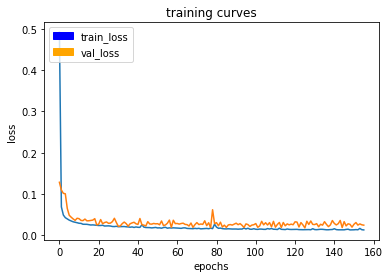

130/129 [==============================] - 72s - loss: 0.0133 - val_loss: 0.0247
Epoch 157/200
129/129 [============================>.] - ETA: 0s - loss: 0.0134

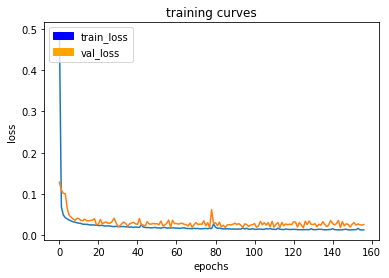

130/129 [==============================] - 72s - loss: 0.0134 - val_loss: 0.0263
Epoch 158/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

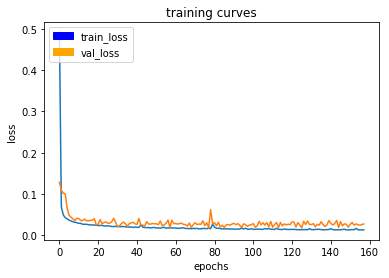

130/129 [==============================] - 73s - loss: 0.0135 - val_loss: 0.0275
Epoch 159/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

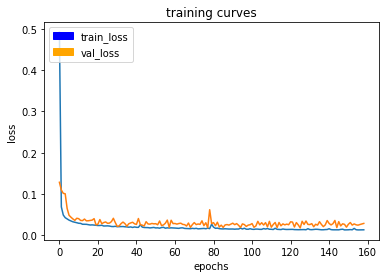

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0289
Epoch 160/200
129/129 [============================>.] - ETA: 0s - loss: 0.0132

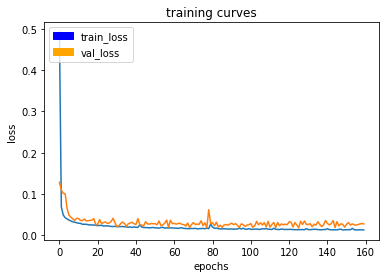

130/129 [==============================] - 72s - loss: 0.0132 - val_loss: 0.0275
Epoch 161/200
129/129 [============================>.] - ETA: 0s - loss: 0.0131

130/129 [==============================] - 72s - loss: 0.0132 - val_loss: 0.0333
Epoch 162/200
129/129 [============================>.] - ETA: 0s - loss: 0.0138

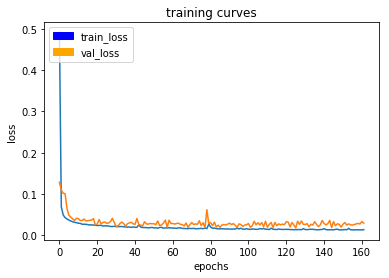

130/129 [==============================] - 72s - loss: 0.0138 - val_loss: 0.0294
Epoch 163/200
129/129 [============================>.] - ETA: 0s - loss: 0.0162

130/129 [==============================] - 72s - loss: 0.0163 - val_loss: 0.0679
Epoch 164/200
129/129 [============================>.] - ETA: 0s - loss: 0.0261

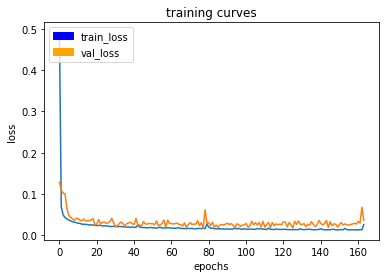

130/129 [==============================] - 72s - loss: 0.0263 - val_loss: 0.0361
Epoch 165/200
129/129 [============================>.] - ETA: 0s - loss: 0.0178

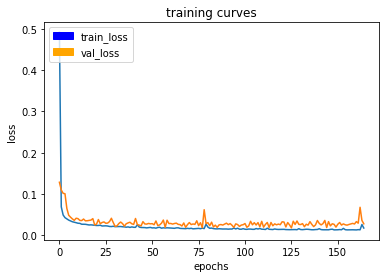

130/129 [==============================] - 72s - loss: 0.0178 - val_loss: 0.0280
Epoch 166/200
129/129 [============================>.] - ETA: 0s - loss: 0.0154

130/129 [==============================] - 72s - loss: 0.0154 - val_loss: 0.0265
Epoch 167/200
129/129 [============================>.] - ETA: 0s - loss: 0.0142

130/129 [==============================] - 72s - loss: 0.0142 - val_loss: 0.0263
Epoch 168/200
129/129 [============================>.] - ETA: 0s - loss: 0.0138

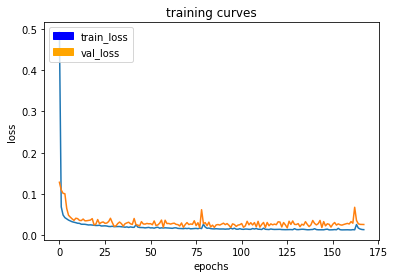

130/129 [==============================] - 72s - loss: 0.0138 - val_loss: 0.0263
Epoch 169/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

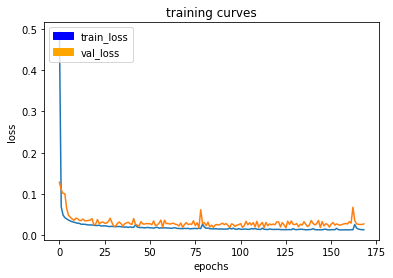

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0277
Epoch 170/200
129/129 [============================>.] - ETA: 0s - loss: 0.0139

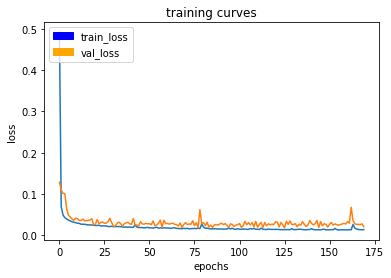

130/129 [==============================] - 72s - loss: 0.0140 - val_loss: 0.0208
Epoch 171/200
129/129 [============================>.] - ETA: 0s - loss: 0.0132

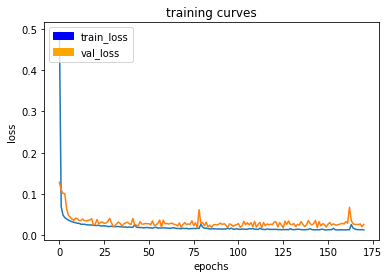

130/129 [==============================] - 72s - loss: 0.0132 - val_loss: 0.0264
Epoch 172/200
129/129 [============================>.] - ETA: 0s - loss: 0.0137

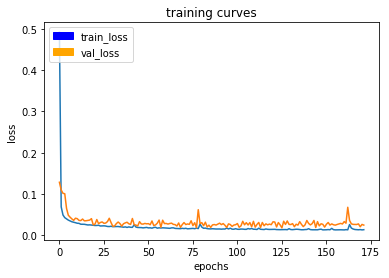

130/129 [==============================] - 72s - loss: 0.0136 - val_loss: 0.0248
Epoch 173/200
129/129 [============================>.] - ETA: 0s - loss: 0.0132

130/129 [==============================] - 72s - loss: 0.0133 - val_loss: 0.0341
Epoch 174/200
129/129 [============================>.] - ETA: 0s - loss: 0.0128

130/129 [==============================] - 72s - loss: 0.0132 - val_loss: 0.0224
Epoch 175/200
129/129 [============================>.] - ETA: 0s - loss: 0.0158

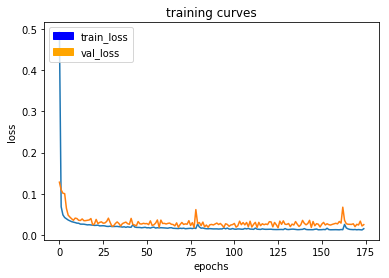

130/129 [==============================] - 72s - loss: 0.0158 - val_loss: 0.0257
Epoch 176/200
129/129 [============================>.] - ETA: 0s - loss: 0.0135

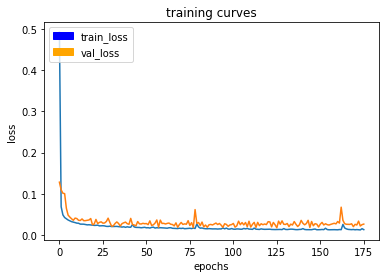

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0270
Epoch 177/200
129/129 [============================>.] - ETA: 0s - loss: 0.0128

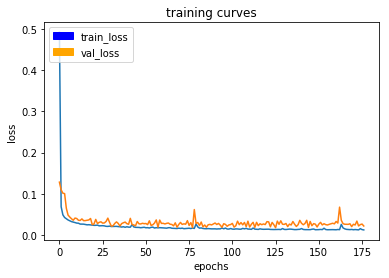

130/129 [==============================] - 72s - loss: 0.0128 - val_loss: 0.0223
Epoch 178/200
129/129 [============================>.] - ETA: 0s - loss: 0.0144

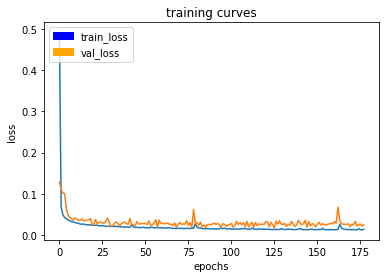

130/129 [==============================] - 72s - loss: 0.0145 - val_loss: 0.0256
Epoch 179/200
129/129 [============================>.] - ETA: 0s - loss: 0.0133

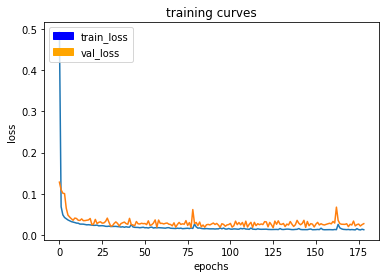

130/129 [==============================] - 72s - loss: 0.0134 - val_loss: 0.0279
Epoch 180/200
129/129 [============================>.] - ETA: 0s - loss: 0.0153

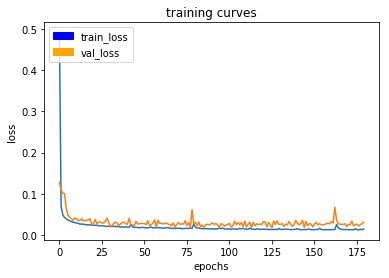

130/129 [==============================] - 72s - loss: 0.0153 - val_loss: 0.0312
Epoch 181/200
129/129 [============================>.] - ETA: 0s - loss: 0.0132

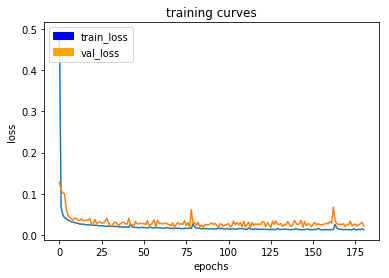

130/129 [==============================] - 72s - loss: 0.0133 - val_loss: 0.0216
Epoch 182/200
129/129 [============================>.] - ETA: 0s - loss: 0.0131

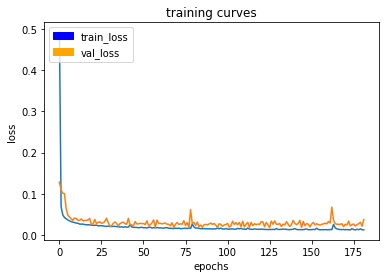

130/129 [==============================] - 72s - loss: 0.0131 - val_loss: 0.0380
Epoch 183/200
129/129 [============================>.] - ETA: 0s - loss: 0.0132

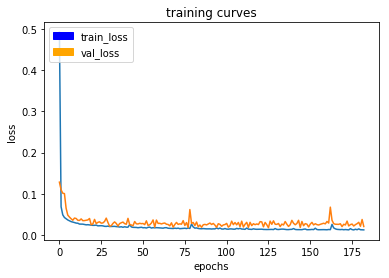

130/129 [==============================] - 72s - loss: 0.0131 - val_loss: 0.0210
Epoch 184/200
129/129 [============================>.] - ETA: 0s - loss: 0.0137

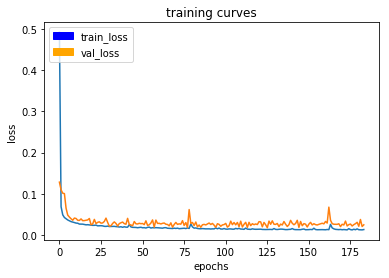

130/129 [==============================] - 72s - loss: 0.0137 - val_loss: 0.0251
Epoch 185/200
129/129 [============================>.] - ETA: 0s - loss: 0.0126

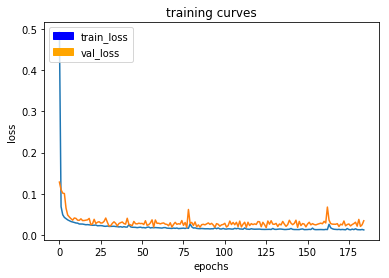

130/129 [==============================] - 72s - loss: 0.0126 - val_loss: 0.0348
Epoch 186/200
129/129 [============================>.] - ETA: 0s - loss: 0.0125

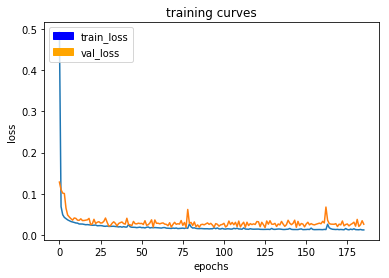

130/129 [==============================] - 72s - loss: 0.0126 - val_loss: 0.0263
Epoch 187/200
129/129 [============================>.] - ETA: 0s - loss: 0.0125

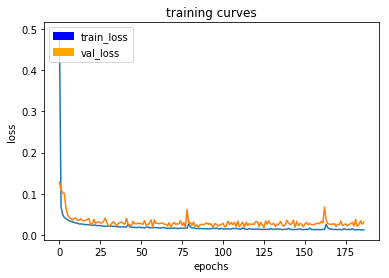

130/129 [==============================] - 72s - loss: 0.0125 - val_loss: 0.0314
Epoch 188/200
129/129 [============================>.] - ETA: 0s - loss: 0.0145

130/129 [==============================] - 72s - loss: 0.0145 - val_loss: 0.0251
Epoch 189/200
129/129 [============================>.] - ETA: 0s - loss: 0.0127

130/129 [==============================] - 72s - loss: 0.0127 - val_loss: 0.0193
Epoch 190/200
129/129 [============================>.] - ETA: 0s - loss: 0.0128

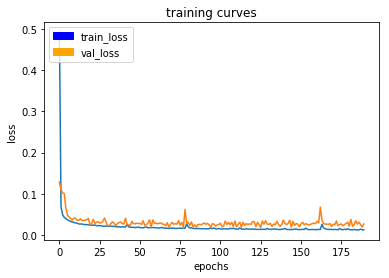

130/129 [==============================] - 72s - loss: 0.0128 - val_loss: 0.0269
Epoch 191/200
129/129 [============================>.] - ETA: 0s - loss: 0.0127

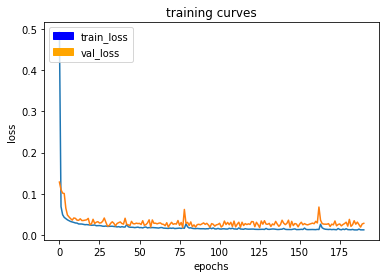

130/129 [==============================] - 72s - loss: 0.0127 - val_loss: 0.0284
Epoch 192/200
129/129 [============================>.] - ETA: 0s - loss: 0.0154

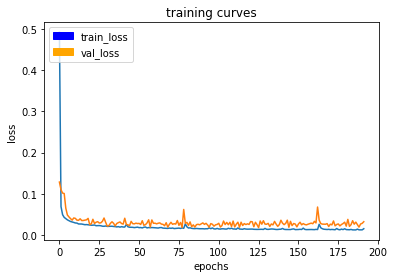

130/129 [==============================] - 72s - loss: 0.0154 - val_loss: 0.0324
Epoch 193/200
129/129 [============================>.] - ETA: 0s - loss: 0.0140

130/129 [==============================] - 72s - loss: 0.0139 - val_loss: 0.0271
Epoch 194/200
129/129 [============================>.] - ETA: 0s - loss: 0.0130

130/129 [==============================] - 72s - loss: 0.0129 - val_loss: 0.0162
Epoch 195/200
129/129 [============================>.] - ETA: 0s - loss: 0.0130

130/129 [==============================] - 72s - loss: 0.0131 - val_loss: 0.0310
Epoch 196/200
129/129 [============================>.] - ETA: 0s - loss: 0.0141

130/129 [==============================] - 72s - loss: 0.0141 - val_loss: 0.0312
Epoch 197/200
129/129 [============================>.] - ETA: 0s - loss: 0.0134

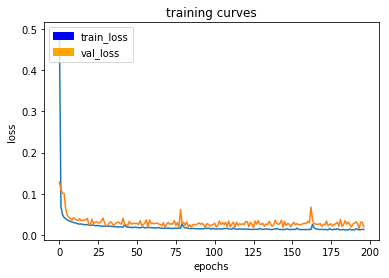

130/129 [==============================] - 72s - loss: 0.0134 - val_loss: 0.0202
Epoch 198/200
129/129 [============================>.] - ETA: 0s - loss: 0.0133

130/129 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0267
Epoch 199/200
129/129 [============================>.] - ETA: 0s - loss: 0.0136

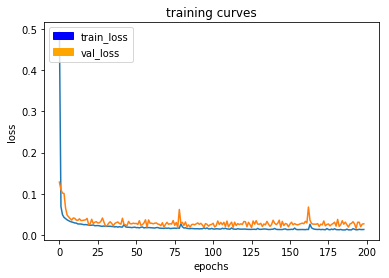

130/129 [==============================] - 72s - loss: 0.0136 - val_loss: 0.0272
Epoch 200/200
129/129 [============================>.] - ETA: 0s - loss: 0.0140

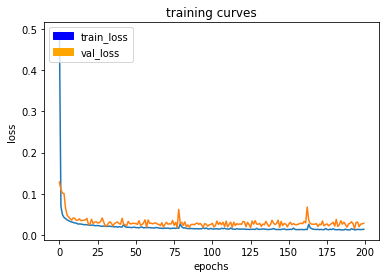

130/129 [==============================] - 72s - loss: 0.0140 - val_loss: 0.0287


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

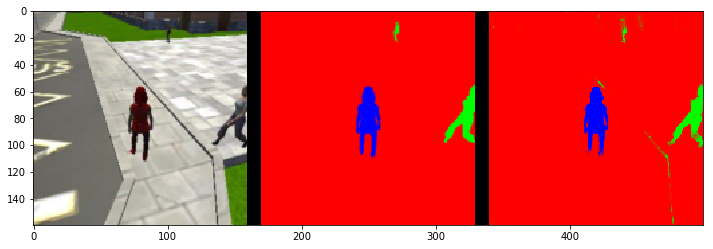

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

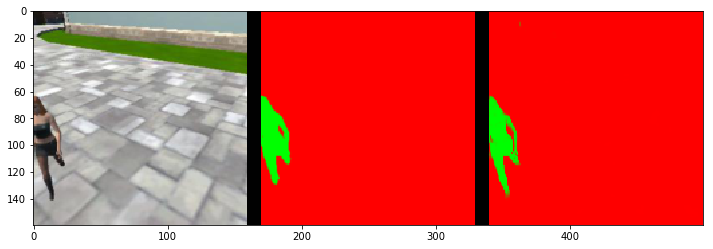

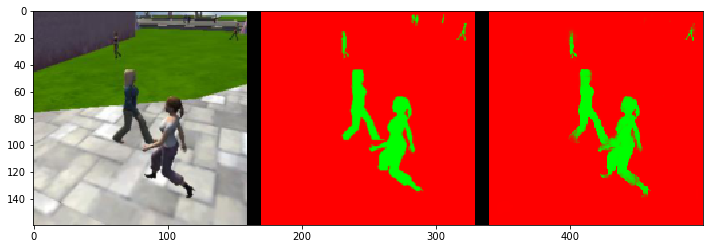

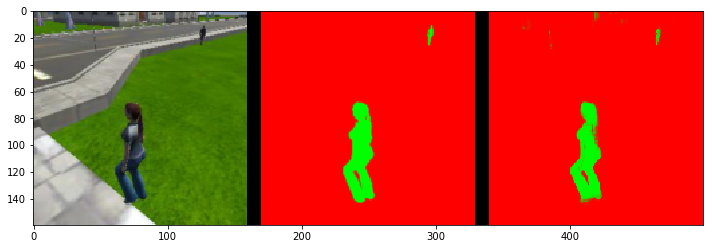

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

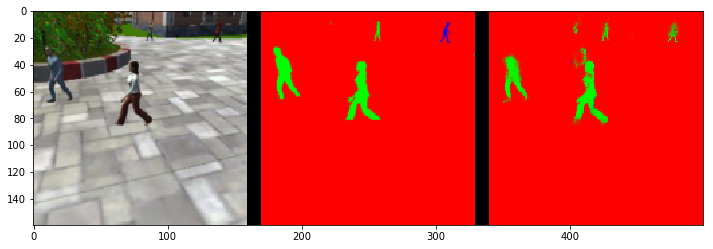

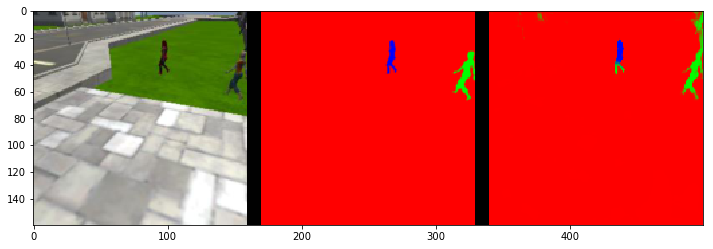

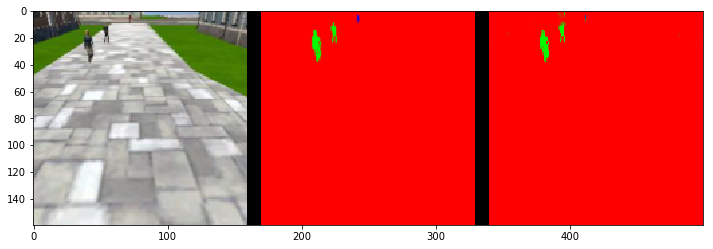

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9956373365067234
average intersection over union for other people is 0.363042024157138
average intersection over union for the hero is 0.9006059628505421
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9883780944871384
average intersection over union for other people is 0.7680398719630679
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 38, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9967541315956967
average intersection over union for other people is 0.46413593331030945
average intersection over union for the hero is 0.27481280189501595
number true positives: 152, number false positives: 3, number false negatives: 149


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7843359818388195


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.587709382373


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.460961615459
